In [15]:
from ellipse_rcnn.pl import EllipseRCNNModule
from ellipse_rcnn.data.industry import IndustryEllipseDataset
from ellipse_rcnn.utils.viz import plot_ellipses, plot_bboxes
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
from ellipse_rcnn.core.types import ImageTargetTuple, TargetDict
import torch
import math

In [42]:
image_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\images'
annotations_dir = r'D:\Exercises\HIWI\EllipDet-master\Industrial\gt'
model_path = r"D:\Exercises\HIWI\ellipse-rcnn-main\checkpoints\loss=0.14624-e=38.ckpt"
image_files = sorted([
            os.path.join(image_dir, f)
            for f in os.listdir(image_dir)
            if f.endswith(".jpg") or f.endswith(".bmp")  # Include both .jpg and .bmp files
        ])
annotation_files = sorted([
        os.path.join(annotations_dir, f)
        for f in os.listdir(annotations_dir)
        if f.endswith(".txt")
    ])
ds = IndustryEllipseDataset(
                image_files,
                annotation_files,
            )
idx = 75
image,target = ds[idx]
image = image.permute(1, 2, 0).numpy()
image = (cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
image_tensor = torch.from_numpy(image)
image_tensor = image_tensor.permute(2, 0, 1)

Processing sample 75
Loading image: D:\Exercises\HIWI\EllipDet-master\Industrial\images\x3.bmp
original size: 1024 x 856
target size_1: 640 x 640


In [43]:
print(f'target: {target}')

target: {'boxes': tensor([[ 85.0560,  59.7831, 544.9440, 612.2169],
        [ 98.1316,  78.3988, 533.8684, 593.6012],
        [134.3748, 125.9147, 499.6252, 548.0853],
        [121.6270, 113.5834, 510.3730, 558.4166],
        [108.8569,  93.6386, 521.1431, 578.3614]]), 'labels': tensor([1, 1, 1, 1, 1]), 'image_id': tensor([75]), 'area': tensor([254057.6719, 224492.6406, 154198.0312, 172927.1406, 199844.4844]), 'iscrowd': tensor([0, 0, 0, 0, 0]), 'ellipse_params': tensor([[ 2.2900e+02,  2.7700e+02,  3.1500e+02,  3.3600e+02, -1.3396e-01],
        [ 2.1500e+02,  2.6000e+02,  3.1600e+02,  3.3600e+02,  2.4341e-01],
        [ 1.7800e+02,  2.1500e+02,  3.1700e+02,  3.3700e+02,  3.4552e-01],
        [ 1.8900e+02,  2.2700e+02,  3.1600e+02,  3.3600e+02,  3.6932e-01],
        [ 2.0300e+02,  2.4500e+02,  3.1500e+02,  3.3600e+02,  2.6450e-01]])}


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


ellipses: tensor([[3.0021e+02, 2.0993e+02, 3.6472e+02, 3.0315e+02, 4.2954e-01],
        [2.0767e+02, 1.5239e+02, 3.6606e+02, 3.1846e+02, 3.2464e-01],
        [2.1688e+02, 1.6018e+02, 2.2133e+02, 3.2363e+02, 2.2950e-01]],
       grad_fn=<ViewBackward0>)
target: tensor([[ 2.2900e+02,  2.7700e+02,  3.1500e+02,  3.3600e+02, -1.3396e-01],
        [ 2.1500e+02,  2.6000e+02,  3.1600e+02,  3.3600e+02,  2.4341e-01],
        [ 1.7800e+02,  2.1500e+02,  3.1700e+02,  3.3700e+02,  3.4552e-01],
        [ 1.8900e+02,  2.2700e+02,  3.1600e+02,  3.3600e+02,  3.6932e-01],
        [ 2.0300e+02,  2.4500e+02,  3.1500e+02,  3.3600e+02,  2.6450e-01]])
Image shape: (640, 640, 3)
Center: (364, 303)
Axes lengths: (300, 209)
Angle: 24.610879126848445
Image shape: (640, 640, 3)
Center: (366, 318)
Axes lengths: (207, 152)
Angle: 18.600217034588844
Image shape: (640, 640, 3)
Center: (221, 323)
Axes lengths: (216, 160)
Angle: 13.149357246703488


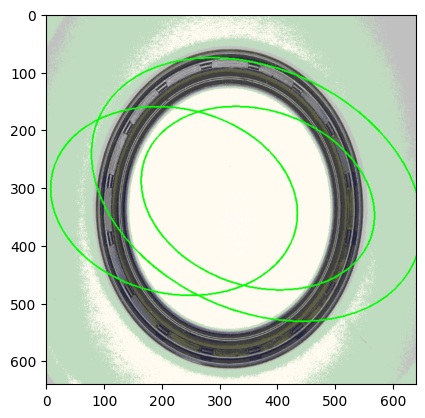

In [44]:
model = EllipseRCNNModule.load_from_checkpoint(model_path)
model.eval().cpu()

pred = model(image_tensor.unsqueeze(0))
score_mask = pred[0]["scores"] > 0.5
if not len(pred[0]["boxes"][score_mask]) > 0:
    print(f"No predictions detected for sampled image {idx + 1}.")
# fig, ax = plt.subplots(figsize=(10, 10)) 

# ax.set_aspect("equal")
# ax.axis("off")
# # image = image.permute(1, 2, 0) if image.ndim == 3 else image
# ax.imshow(image, cmap="grey")

ellipses = pred[0]["ellipse_params"][score_mask].view(-1, 5)
boxes = pred[0]["boxes"][score_mask].view(-1, 4)
print(f'ellipses: {ellipses}')
print(f"target: {target['ellipse_params']}")
# if image.dtype != np.uint8:
#     image = (image * 255).astype(np.uint8) 
# ellipse_params = target["ellipse_params"]

for params in ellipses:
    # Extracting parameters
    
    axis_length_1 = int(params[0])   # X coordinate of center
    axis_length_2 = int(params[1])   # Y coordinate of center
    center_x = int(params[2])    # Semi-major axis length (half-length)
    center_y = int(params[3])    # Semi-minor axis length (half-length)
    angle = float(params[4]) * (180 / np.pi)   # Convert radians to degrees if necessary
    print("Image shape:", image.shape)      # Should show H x W x C
    print("Center:", (center_x, center_y))
    print("Axes lengths:", (axis_length_1, axis_length_2))
    print("Angle:", angle)
    
    cv2.ellipse(
    image,
    (center_x, center_y),  # Center
    (axis_length_1, axis_length_2),  # Axes lengths should be half-lengths
    angle,
    0,
    360,
    (0, 255, 0),  # Color
    2)                # Thickness (-1 means filled)

# # Plot ellipses
# plot_ellipses(
#     ellipses,
#     ax=ax,
#     plot_centers=False, # Whehter to plot ellipse centers
#     rim_color="b",
#     alpha=1,
# )
# plot_ellipses(
#             target["ellipse_params"],
#             ax=ax,
#             plot_centers=False,
#             rim_color="r",
#             alpha=1,
#         )
plt.imshow(image)
plt.show()

In [30]:
image.shape

(640, 640, 3)